[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# State Schema

## Review

In module 1, we laid the foundations! We built up to an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions

And, we showed how to serve it locally in LangGraph Studio or deploy it with LangGraph Cloud.

## Goals

In this module, we're going to build a deeper understanding of both state and memory.

First, let's review a few different ways to define your state schema.

In [35]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

## TypedDict

As we mentioned in Module 1, we can use the `TypedDict` class from python's `typing` module.

It allows you to specify keys and their corresponding value types.

But, note that these are type hints.

They can be used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run.

But they are not enforced at runtime!

In [36]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints, you can use things like the `Literal` type hint.

Here, `mood` can only be either "happy" or "sad".

In [37]:
from typing import TypedDict, Literal

class WeatherReport(TypedDict):
    city: str
    condition: Literal["sunny", "rainy", "cloudy", "stormy"]


We can use our defined state class (e.g., here `TypedDictState`) in LangGraph by simply passing it to `StateGraph`.

And, we can think about each state key as just a "channel" in our graph.

As discussed in Module 1, we overwrite the value of a specified key or "channel" in each node.

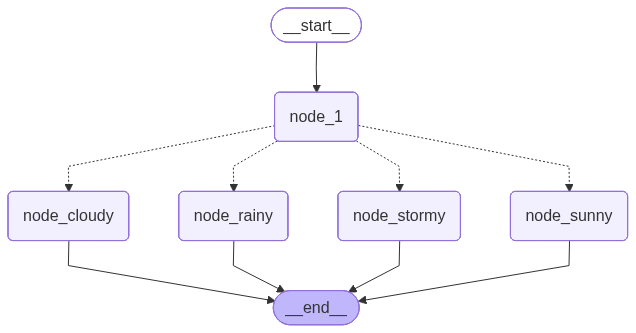

In [38]:
import random
from typing import TypedDict, Literal
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define state
class WeatherState(TypedDict):
    city: str
    condition: Literal["sunny", "rainy", "cloudy", "stormy"]

# Define nodes
def node_1(state):
    print("---Node 1---")
    return {"city": state['city'] + " Weather Update: "}

def node_sunny(state):
    print("---Sunny Node---")
    return {"condition": "sunny"}

def node_rainy(state):
    print("---Rainy Node---")
    return {"condition": "rainy"}

def node_cloudy(state):
    print("---Cloudy Node---")
    return {"condition": "cloudy"}

def node_stormy(state):
    print("---Stormy Node---")
    return {"condition": "stormy"}

# Decide which weather node to go to
def decide_weather(state) -> Literal["node_sunny", "node_rainy", "node_cloudy", "node_stormy"]:
    r = random.random()
    if r < 0.25:
        return "node_sunny"
    elif r < 0.5:
        return "node_rainy"
    elif r < 0.75:
        return "node_cloudy"
    else:
        return "node_stormy"

# Build graph
builder = StateGraph(WeatherState)
builder.add_node("node_1", node_1)
builder.add_node("node_sunny", node_sunny)
builder.add_node("node_rainy", node_rainy)
builder.add_node("node_cloudy", node_cloudy)
builder.add_node("node_stormy", node_stormy)

# Add edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_weather)
builder.add_edge("node_sunny", END)
builder.add_edge("node_rainy", END)
builder.add_edge("node_cloudy", END)
builder.add_edge("node_stormy", END)

# Compile graph
graph = builder.compile()

# Display flowchart
display(Image(graph.get_graph().draw_mermaid_png()))


Because our state is a dict, we simply invoke the graph with a dict to set an initial value of the `name` key in our state.

In [39]:
graph.invoke({"city": "Lance"})


---Node 1---
---Stormy Node---


{'city': 'Lance Weather Update: ', 'condition': 'stormy'}

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [40]:
from dataclasses import dataclass
from typing import Literal

@dataclass
class WeatherData:
    city: str
    condition: Literal["sunny", "rainy", "cloudy", "stormy"]


To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`:

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.

This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

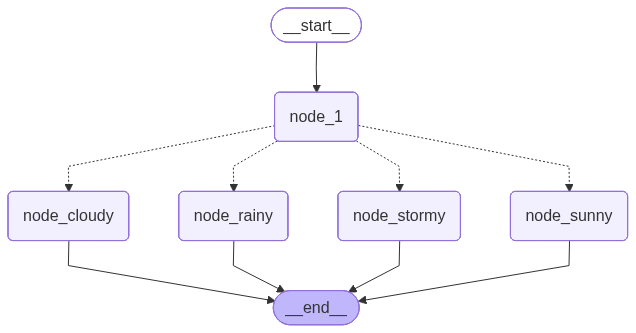

In [41]:
import random
from dataclasses import dataclass
from typing import Literal
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Dataclass state
@dataclass
class WeatherData:
    city: str
    condition: Literal["sunny", "rainy", "cloudy", "stormy"]

# Define nodes
def node_1(state: WeatherData):
    print("---Node 1---")
    return {"city": state.city + " Weather Update: "}

def node_sunny(state: WeatherData):
    print("---Sunny Node---")
    return {"condition": "sunny"}

def node_rainy(state: WeatherData):
    print("---Rainy Node---")
    return {"condition": "rainy"}

def node_cloudy(state: WeatherData):
    print("---Cloudy Node---")
    return {"condition": "cloudy"}

def node_stormy(state: WeatherData):
    print("---Stormy Node---")
    return {"condition": "stormy"}

# Decide which weather node to go to
def decide_weather(state: WeatherData) -> Literal["node_sunny", "node_rainy", "node_cloudy", "node_stormy"]:
    r = random.random()
    if r < 0.25:
        return "node_sunny"
    elif r < 0.5:
        return "node_rainy"
    elif r < 0.75:
        return "node_cloudy"
    else:
        return "node_stormy"

# Build graph
builder = StateGraph(WeatherData)
builder.add_node("node_1", node_1)
builder.add_node("node_sunny", node_sunny)
builder.add_node("node_rainy", node_rainy)
builder.add_node("node_cloudy", node_cloudy)
builder.add_node("node_stormy", node_stormy)

# Add edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_weather)
builder.add_edge("node_sunny", END)
builder.add_edge("node_rainy", END)
builder.add_edge("node_cloudy", END)
builder.add_edge("node_stormy", END)

# Compile graph
graph = builder.compile()

# Display flowchart
display(Image(graph.get_graph().draw_mermaid_png()))


We invoke with a `dataclass` to set the initial values of each key / channel in our state!

In [46]:
graph.invoke(PydanticWeather(city="Lance", condition="crazy"))


ValidationError: 1 validation error for PydanticWeather
condition
  Value error, Each condition must be one of ['sunny', 'rainy', 'cloudy', 'stormy'] [type=value_error, input_value='crazy', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime.

This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [ ]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations.

It's particularly well-suited [for defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/) due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [ ]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticWeather(BaseModel):
    city: str
    condition: str  # "sunny", "rainy", "cloudy", or "stormy"

    @field_validator('condition')
    @classmethod
    def validate_condition(cls, value):
        allowed_conditions = ["sunny", "rainy", "cloudy", "stormy"]
        if value not in allowed_conditions:
            raise ValueError(f"Each condition must be one of {allowed_conditions}")
        return value

# Example usage
try:
    weather = PydanticWeather(city="Delhi", condition="snowy")
except ValidationError as e:
    print("Validation Error:", e)

# Correct usage
weather = PydanticWeather(city="Delhi", condition="sunny")
print(weather)


We can use `PydanticState` in our graph seamlessly.

In [ ]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, field_validator, ValidationError
from typing import Literal

# Pydantic state
class PydanticWeather(BaseModel):
    city: str
    condition: str  # "sunny", "rainy", "cloudy", or "stormy"

    @field_validator('condition')
    @classmethod
    def validate_condition(cls, value):
        allowed_conditions = ["sunny", "rainy", "cloudy", "stormy"]
        if value not in allowed_conditions:
            raise ValueError(f"Each condition must be one of {allowed_conditions}")
        return value

# Define nodes
def node_1(state: PydanticWeather):
    print("---Node 1---")
    return {"city": state.city + " Weather Update: "}

def node_sunny(state: PydanticWeather):
    print("---Sunny Node---")
    return {"condition": "sunny"}

def node_rainy(state: PydanticWeather):
    print("---Rainy Node---")
    return {"condition": "rainy"}

def node_cloudy(state: PydanticWeather):
    print("---Cloudy Node---")
    return {"condition": "cloudy"}

def node_stormy(state: PydanticWeather):
    print("---Stormy Node---")
    return {"condition": "stormy"}

# Decide which weather node to go to
def decide_weather(state: PydanticWeather) -> Literal["node_sunny", "node_rainy", "node_cloudy", "node_stormy"]:
    r = random.random()
    if r < 0.25:
        return "node_sunny"
    elif r < 0.5:
        return "node_rainy"
    elif r < 0.75:
        return "node_cloudy"
    else:
        return "node_stormy"

# Build graph
builder = StateGraph(PydanticWeather)
builder.add_node("node_1", node_1)
builder.add_node("node_sunny", node_sunny)
builder.add_node("node_rainy", node_rainy)
builder.add_node("node_cloudy", node_cloudy)
builder.add_node("node_stormy", node_stormy)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_weather)
builder.add_edge("node_sunny", END)
builder.add_edge("node_rainy", END)
builder.add_edge("node_cloudy", END)
builder.add_edge("node_stormy", END)

# Compile graph
graph = builder.compile()

# View flowchart
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph.invoke(PydanticWeather(city="Delhi", condition="sunny"))


In [ ]:
graph.invoke(PydanticWeather(city="Banglore", condition="Stormy"))  # This will raise a ValidationError as we require
